# Ensemble methods

## 1. Importing the data

We'll use the same data set whe used in the last lab. The salary data set was extracted from the census bureau database and contains salary information. The goal is to use this data set and to try to draw conclusions regarding what drives salaries. More specifically, the target variable is categorical (> 50k; <= 50 k). Let's create a classification tree!

In [301]:
import pandas as pd
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
import sklearn as skl
import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model
from sklearn.cross_validation import train_test_split
import sklearn.metrics as metrics
import sklearn.tree as tree
import seaborn as sns
import graphviz 
from sklearn.tree import export_graphviz

In [27]:
salaries = pd.read_csv("salaries_final.csv", index_col = 0)

In total, there are 6 predictors, and one outcome variable, the target salary <= 50k/ >50k.

recall that the 6 predictors are:

- `Age`: continuous.

- `Education`: Categorical. Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, 
Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.

- `Occupation`: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.

- `Relationship`: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.

- `Race`: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.

- `Sex`: Female, Male.

In [28]:
salaries.head()

,Age,Education,Occupation,Relationship,Race,Sex,Target
0,39,Bachelors,Adm-clerical,Not-in-family,White,Male,<=50K
1,50,Bachelors,Exec-managerial,Husband,White,Male,<=50K
2,38,HS-grad,Handlers-cleaners,Not-in-family,White,Male,<=50K
3,53,11th,Handlers-cleaners,Husband,Black,Male,<=50K
4,28,Bachelors,Prof-specialty,Wife,Black,Female,<=50K


Let's use `dmatrices` again to get to the right format to start making our trees.

In [267]:
from patsy import dmatrices
target, data = dmatrices('Target ~ Age + C(Education) + \
                  C(Occupation) + C(Relationship) + C(Race) + C(Sex)',
                  salaries, return_type = "dataframe")

Make a train and test split

In [30]:
data_train, data_test, target_train, target_test = train_test_split(data, target, 
                                                                   test_size = 0.25, random_state=123)

## 2. Let's rebuild a "regular" tree as a baseline

### 2.1 Building the tree

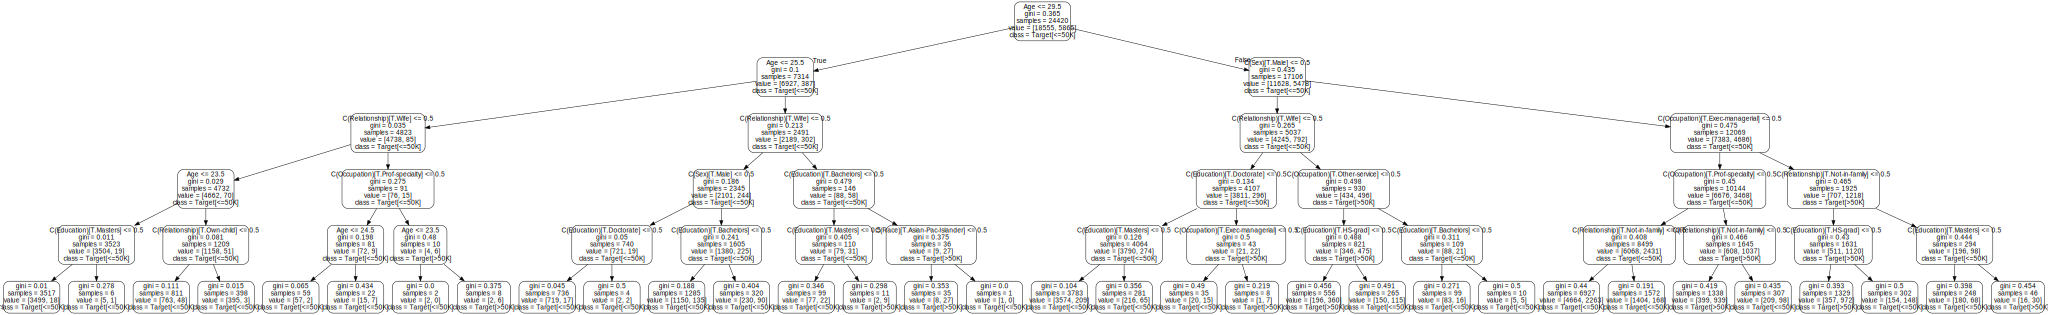

In [354]:
from sklearn import tree
tree = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 5) 
tree = tree.fit(data_train, target_train.iloc[:,1])

export_graphviz(tree, out_file="mytree.dot", feature_names=data_train.columns , class_names=list(target_train), rounded=True)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

### 2.1 Feature importance

In [158]:
tree.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01174726,
       0.00731382, 0.01770231, 0.01362388, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.10865096,
       0.        , 0.        , 0.        , 0.01126856, 0.        ,
       0.13019604, 0.        , 0.        , 0.        , 0.        ,
       0.10188485, 0.        , 0.00056004, 0.        , 0.13774195,
       0.00045497, 0.        , 0.        , 0.        , 0.15438617,
       0.30446918])

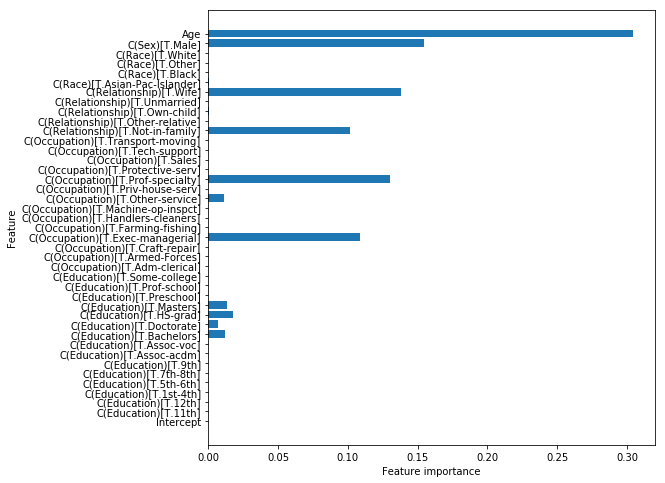

In [234]:
def plot_feature_importances(model):
    n_features = data_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), data_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(tree)

### 2.3 Model performance

In [106]:
from sklearn.metrics import accuracy_score

In [268]:
pred= tree.predict(data_test)
print(metrics.confusion_matrix(target_test.iloc[:,1], pred))
print(metrics.classification_report(target_test.iloc[:,1], pred))

[[5825  340]
 [1201  775]]
             precision    recall  f1-score   support

        0.0       0.83      0.94      0.88      6165
        1.0       0.70      0.39      0.50      1976

avg / total       0.80      0.81      0.79      8141



In [108]:
accuracy_score(target_test.iloc[:,1], pred)

0.810711214838472

## 3. Bagged trees

In [288]:
from sklearn.ensemble import BaggingClassifier

In [314]:
bagged_tree =  BaggingClassifier(tree.DecisionTreeClassifier(criterion = "gini", max_depth = 5), n_estimators=20)

In [315]:
bagged_tree.fit(data_train, target_train.iloc[:,1])

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=20, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [316]:
bagged_tree.score(data_train, target_train.iloc[:,1])

0.8161343161343161

In [317]:
bagged_tree.score(data_test, target_test.iloc[:,1])

0.8151332760103182

## 4. Random forests

### 4.1 Fitting a random forests model

In [226]:
from sklearn.ensemble import RandomForestClassifier 

The default for `max_features` is `auto`. This means sqrt(total n of features) 

In [227]:
forest = RandomForestClassifier(n_estimators=100, max_features= 20, random_state=123, max_depth= 5)
forest.fit(data_train, target_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=20, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [311]:
forest.score(data_train, target_train)

0.8177313677313678

In [229]:
forest.score(data_test, target_test)

0.8170986365311387

### 4.2 Look at the feature importances

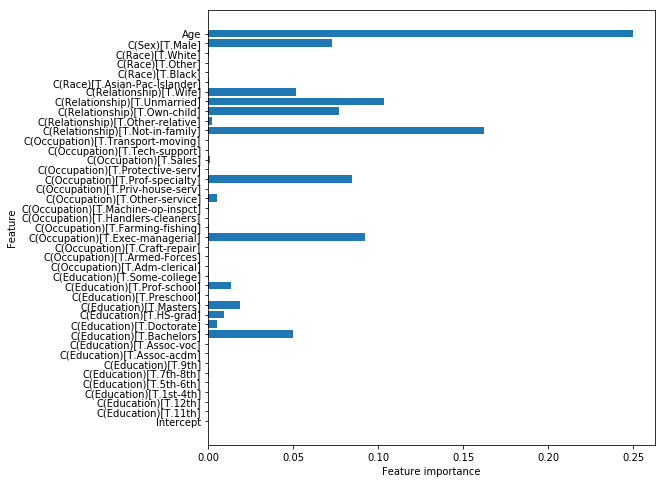

In [235]:
plot_feature_importances(forest)

Note: "relationship" represents what this individual is relative to others. For example an
individual could be a Husband. Each entry only has one relationship, so it is a bit of a weird attribute.

Note that more geatures show up. This is a pretty typical result. 

### 4.3 Look at the trees in your forest

Let's create a forest with some small trees. You'll learn how to access trees in your forest!

In [198]:
forest_2 = RandomForestClassifier(n_estimators = 5, max_features= 10, random_state=123, max_depth= 2)
forest_2.fit(data_train, target_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

Making `max_features` smaller will lead to very different trees in your forest!

The trees in your forest are stored in the `.estimators_` attribute.

In [199]:
forest_2.estimators_[0]

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=843828734, splitter='best')

In [200]:
forest_2.estimators_[1]

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=914636141, splitter='best')

In [204]:
tree_1 = forest_2.estimators_[0].fit(data_train, target_train.iloc[:,1])

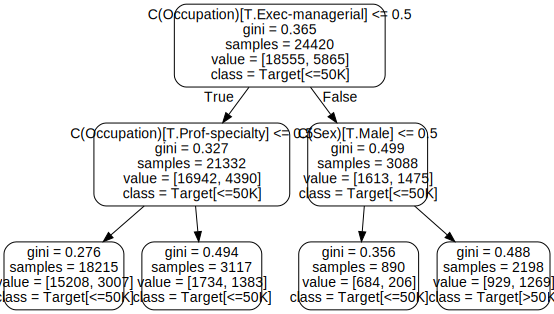

In [205]:
export_graphviz(tree_1, out_file="mytree.dot", feature_names=data_train.columns , class_names=list(target_train), rounded=True)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

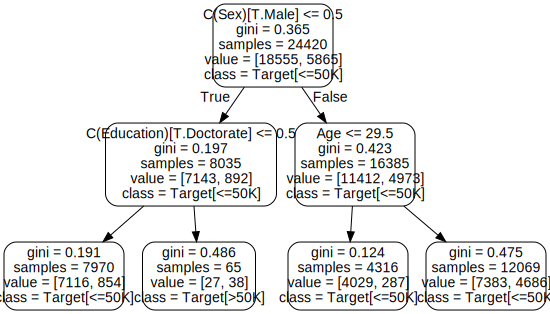

In [246]:
tree_2 = forest_2.estimators_[1].fit(data_train, target_train.iloc[:,1])
export_graphviz(tree_2, out_file="mytree.dot", feature_names=data_train.columns , class_names=list(target_train), rounded=True)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

## 5. Gradient boosting

### 5.1 GBRT

#### 5.1.1 Fitting a GBRT model

In [242]:
gradboost = GradientBoostingClassifier(random_state = 123, max_depth = 5, learning_rate = 0.01)
gradboost.fit(data_train, target_train.iloc[:,1])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=123, subsample=1.0, verbose=0,
              warm_start=False)

In [243]:
gradboost.score(data_train, target_train.iloc[:,1])

0.8041359541359542

In [244]:
gradboost.score(data_test, target_test.iloc[:,1])

0.8024812676575359

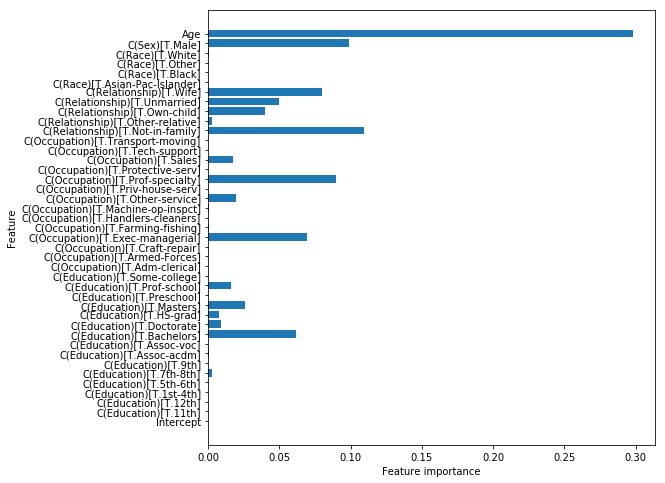

In [245]:
plot_feature_importances(gradboost)

This isn't really an improvement compared to our Random forests. We told you that gradient boosting methods can generate excellent results, if you set your hyperparameters right! As you know, gradient descent is a delicate process and the learning rate should be set correctly. Let's have a look at what changing the learning rate does to our model.

#### 5.1.2 Changing the learning rate

In [263]:
gradboost_2 = GradientBoostingClassifier(random_state = 123, max_depth = 5, learning_rate = 0.09)
gradboost_2.fit(data_train, target_train.iloc[:,1])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.09, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=123, subsample=1.0, verbose=0,
              warm_start=False)

In [264]:
gradboost_2.score(data_train, target_train.iloc[:,1])

0.8422604422604423

In [265]:
gradboost_2.score(data_test, target_test.iloc[:,1])

0.8354010563812799

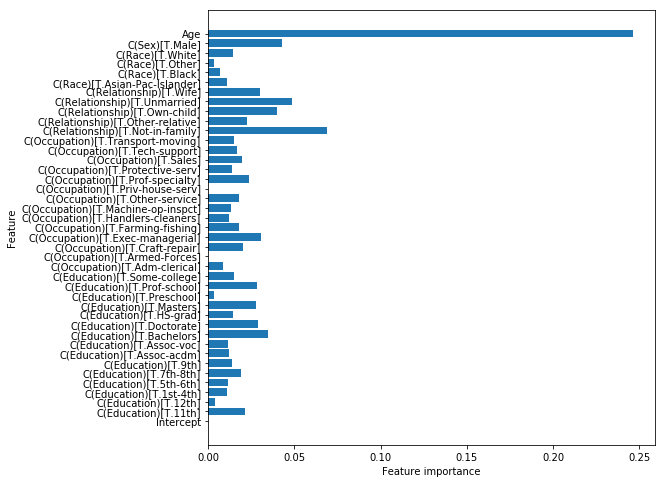

In [266]:
plot_feature_importances(gradboost_2)

The feature importances plot has changed drastically! This model is definitely more complex, as mentioned in the lecture.

### 5.2 AdaBoost

In [318]:
from sklearn.ensemble import AdaBoostClassifier

In [319]:
adaboost = AdaBoostClassifier(random_state = 123, n_estimators=100)
adaboost.fit(data_train, target_train.iloc[:,1])

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=123)

In [320]:
adaboost.score(data_train, target_train.iloc[:,1])

0.8350941850941851

In [321]:
adaboost.score(data_test, target_test.iloc[:,1])

0.8355238914138312

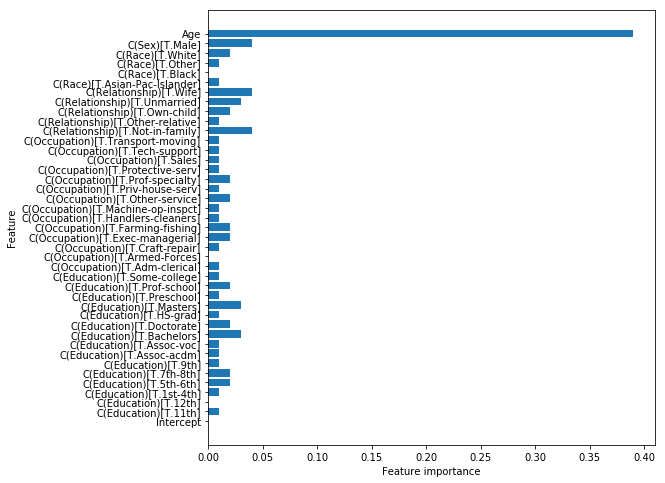

In [322]:
plot_feature_importances(adaboost)

Seems to be performing similarly to gradient boosting, even more focus on Age.

## 6. To wrap up: let's look at a regression tree

In [350]:
# load dataset
data = pd.read_csv("dataset_Facebook.csv", sep = ";", header=0)
data = data.dropna()
data.head()

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,139441,Photo,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,139441,Status,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,139441,Photo,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80
3,139441,Photo,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777
4,139441,Photo,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393


In [351]:
facebook = data[["Page total likes","Type", "Category", "Post Month", "Post Weekday", "Post Hour", "Paid"]]

In [352]:
facebook = facebook.rename(index=str, columns={"Page total likes": "Likes", "Post Month": "Post_month", "Post Weekday": "Post_day", "Post Hour": "Post_hour" })

In [353]:
likes, fb_data = dmatrices('Likes ~ C(Category) + C(Post_month)+ \
                 C(Post_day) + Post_hour + C(Paid) + C(Type)',
                  facebook, return_type = "dataframe")

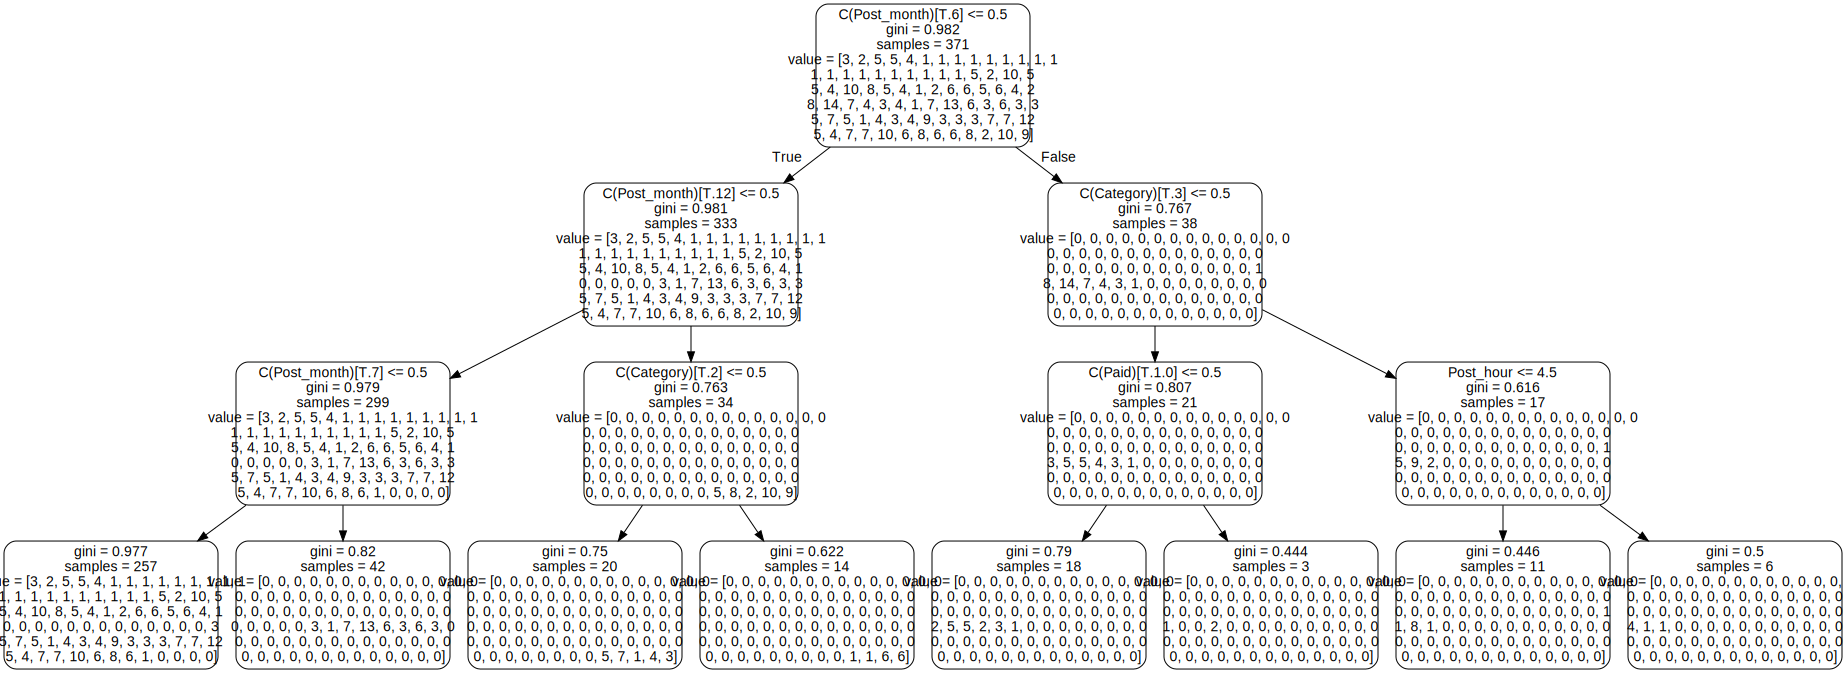

In [368]:
fb_train, fb_test, likes_train, likes_test = train_test_split(fb_data, likes, 
                                                                   test_size = 0.25, random_state=123)
from sklearn import tree
tree = tree.DecisionTreeClassifier(max_depth = 3) 
tree = tree.fit(fb_train, likes_train)

export_graphviz(tree, out_file="mytree.dot", feature_names=fb_train.columns, rounded=True)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

TO DO fix so values are taken out

# Sources
https://www.svds.com/machine-learning-vs-statistics/ 

https://github.com/xbno/Projects/blob/master/Models_Scratch/Decision%20Trees%20from%20scratch.ipynb

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

http://scikit-learn.org/stable/modules/ensemble.html


Raschka and Mirjalili

Muller and Guido


https://machinelearningmastery.com/ensemble-machine-learning-algorithms-python-scikit-learn/